In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F


In [2]:
"""
卷积运算 使用mnist数据集，和10-4，11类似的，只是这里：1.输出训练轮的acc 2.模型上使用torch.nn.Sequential
"""
# Super parameter ------------------------------------------------------------------------------------
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10


In [7]:
# --- 新增代码：检测并指定设备 ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检查 CUDA 是否可用
# 或者如果你有多块GPU，可以指定使用哪一块，例如使用第一块GPU：
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")
# ---------------------------------


Using device: cuda:0


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集


In [5]:
# batch_size = batch_size # 需要定义batch_size变量，例如 batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/anaconda3/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


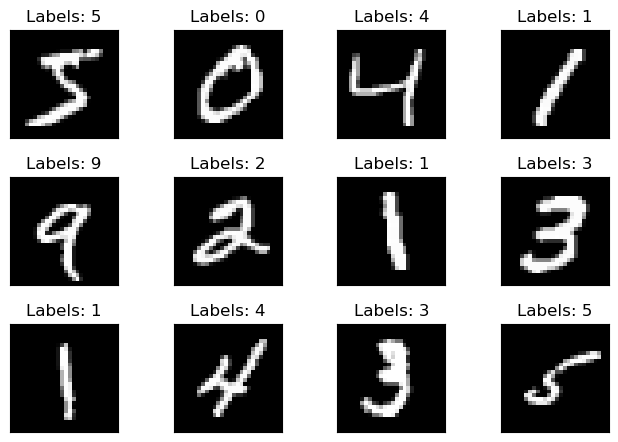

In [6]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    # 注意：直接访问 .train_data 和 .train_labels 是可行的，但更常见和推荐的方式是通过 DataLoader 迭代获取数据。
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none') 
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [8]:
class Net(torch.nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        # 第一个卷积块
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5), # 输入通道1 (灰度图), 输出通道10, 5x5卷积核
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 2x2最大池化
        )
        # 第二个卷积块
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5), # 输入通道10 (来自上一层), 输出通道20, 5x5卷积核
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 2x2最大池化
        )
        # 全连接层
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50), # 输入特征320, 输出特征50
            torch.nn.Linear(50, 10),  # 输入特征50, 输出特征10 (对应0-9十个类别)
        )

    def forward(self, x):
        # x 的初始形状是 (batch_size, 1, 28, 28)
        batch_size = x.size(0) 
        
        # 通过第一个卷积块
        # conv1: Conv2d(1, 10, k=5) -> spatial dim (28 - 5)/1 + 1 = 24x24. Shape becomes (batch_size, 10, 24, 24)
        # ReLU: shape remains (batch_size, 10, 24, 24)
        # MaxPool2d(k=2, s=2 default): spatial dim (24 - 2)/2 + 1 = 12x12. Shape becomes (batch_size, 10, 12, 12)
        x = self.conv1(x)  
        
        # 通过第二个卷积块
        # conv2: Conv2d(10, 20, k=5) -> spatial dim (12 - 5)/1 + 1 = 8x8. Shape becomes (batch_size, 20, 8, 8)
        # ReLU: shape remains (batch_size, 20, 8, 8)
        # MaxPool2d(k=2, s=2 default): spatial dim (8 - 2)/2 + 1 = 4x4. Shape becomes (batch_size, 20, 4, 4)
        x = self.conv2(x)  
        
        # 展平操作 (flatten)
        # 将形状 (batch_size, 20, 4, 4) 展平为 (batch_size, 20 * 4 * 4) = (batch_size, 320)
        x = x.view(batch_size, -1)  
        
        # 通过全连接层
        # fc: Linear(320, 50) -> output shape (batch_size, 50)
        #     Linear(50, 10) -> output shape (batch_size, 10)
        x = self.fc(x)
        
        # 最后输出的是维度为10的，也就是（对应数学符号的0~9）
        return x  


In [9]:
model = Net()

In [10]:
criterion = torch.nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量


In [11]:
# 四、定义训练轮和测试轮

def train(epoch):
    # --- 新增代码：设置模型为训练模式 ---
    model.train() # [^digitalocean.com_train]
    # -----------------------------------
    
    running_loss = 0.0  # 累积每个小批次的损失
    running_total = 0   # 累积每个小批次的样本总数
    running_correct = 0 # 累积每个小批次的正确预测数

    # 遍历 train_loader 中的每一个数据批次
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        
        # --- 修改代码：将数据移动到指定设备 ---
        inputs, target = inputs.to(device), target.to(device) # [^pytorch.org_move][^medium.com_to_device][^wandb.ai]
        # ---------------------------------------
        
        optimizer.zero_grad() # 梯度清零

        # forward + backward + update
        outputs = model(inputs) # 模型在前向传播中处理设备上的数据
        loss = criterion(outputs, target) # 损失函数计算设备上的输出和目标
        loss.backward() # 反向传播计算设备上的梯度
        optimizer.step() # 优化器更新设备上的模型参数

        # --- 训练过程中的指标记录 ---
        running_loss += loss.item() # loss.item() 将设备上的损失值转为 Python 标量
        
        # 计算当前批次的预测结果
        # torch.max 在设备上执行，但 .data 和 item() 将结果转回 Python/CPU
        _, predicted = torch.max(outputs.data, dim=1) # [^pytorch.org_max][^geeksforgeeks.org_max]
        
        # 累加当前批次的样本总数
        running_total += inputs.shape[0]
        
        # 计算当前批次正确预测的数量 (比较和求和都在设备上执行，item() 转回 Python)
        running_correct += (predicted == target).sum().item() 

        # 每处理 300 个批次，打印一次当前的平均损失和准确率
        if batch_idx % 300 == 299:  
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            # 打印后，将用于累积的变量清零
            running_loss = 0.0  
            running_total = 0
            running_correct = 0

In [12]:
# test 函数 (需要在调用 test 函数前定义全局变量 EPOCH 或者将其作为参数传入 test 函数)
def test(epoch): # 将 epoch 作为参数传入，使函数更独立
    # --- 新增代码：设置模型为评估模式 ---
    model.eval() # [^digitalocean.com_train]
    # -----------------------------------
    
    correct = 0  # 累积整个测试集的正确预测数
    total = 0    # 累积整个测试集的样本总数

    # 使用 torch.no_grad() 上下文管理器：在测试/推理阶段不计算梯度，节省内存和加速。 [^pytorch.org_no_grad][^digitalocean.com_train]
    with torch.no_grad():  
        for data in test_loader:
            images, labels = data
            
            # --- 修改代码：将数据移动到指定设备 ---
            images, labels = images.to(device), labels.to(device) # [^pytorch.org_move][^medium.com_to_device][^wandb.ai]
            # -------------------------------------
            
            outputs = model(images) # 模型在前向传播中处理设备上的数据
            
            # 获取预测结果
            _, predicted = torch.max(outputs.data, dim=1) # [^pytorch.org_max][^geeksforgeeks.org_max]
            
            # 累加当前批次的样本总数
            total += labels.size(0)  
            
            # 累加当前批次正确预测的数量 (比较和求和都在设备上执行，item() 转回 Python)
            correct += (predicted == labels).sum().item() 
    
    # 计算整个测试集的准确率
    acc = correct / total
    
    # 打印当前 epoch 的测试集准确率
    # epoch 和 EPOCH 通过函数参数和全局变量获取
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc)) 
    
    # 返回计算出的准确率
    return acc


[1,   300]: loss: 0.816 , acc: 77.15 %
[1,   600]: loss: 0.226 , acc: 93.31 %
[1,   900]: loss: 0.157 , acc: 95.23 %
[1 / 10]: Accuracy on test set: 96.4 % 
[2,   300]: loss: 0.115 , acc: 96.47 %
[2,   600]: loss: 0.111 , acc: 96.64 %
[2,   900]: loss: 0.100 , acc: 97.03 %
[2 / 10]: Accuracy on test set: 97.7 % 
[3,   300]: loss: 0.086 , acc: 97.53 %
[3,   600]: loss: 0.078 , acc: 97.49 %
[3,   900]: loss: 0.075 , acc: 97.69 %
[3 / 10]: Accuracy on test set: 98.0 % 
[4,   300]: loss: 0.074 , acc: 97.75 %
[4,   600]: loss: 0.062 , acc: 98.07 %
[4,   900]: loss: 0.065 , acc: 97.99 %
[4 / 10]: Accuracy on test set: 98.4 % 
[5,   300]: loss: 0.058 , acc: 98.26 %
[5,   600]: loss: 0.060 , acc: 98.12 %
[5,   900]: loss: 0.053 , acc: 98.44 %
[5 / 10]: Accuracy on test set: 98.6 % 
[6,   300]: loss: 0.054 , acc: 98.28 %
[6,   600]: loss: 0.053 , acc: 98.48 %
[6,   900]: loss: 0.045 , acc: 98.60 %
[6 / 10]: Accuracy on test set: 98.5 % 
[7,   300]: loss: 0.043 , acc: 98.67 %
[7,   600]: loss: 0

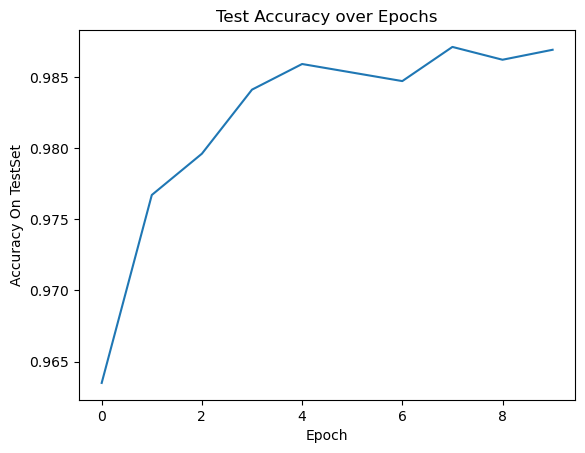

In [13]:
# 五、开始训练

if __name__ == '__main__':
    # --- 修改代码：实例化模型后，立即将其移动到指定设备 ---
    model = Net().to(device) # [^pytorch.org_move_model][^medium.com_to_device][^wandb.ai]
    # -------------------------------------------------------
    
    # 优化器定义 (在模型已经移动到设备后定义，这样优化器跟踪的就是设备上的参数)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 

    acc_list_test = [] # 用于存储每个epoch结束时在测试集上的准确率
    
    # 主循环，迭代进行 EPOCH 次训练和测试
    for epoch in range(EPOCH): 
        # 调用 train 函数进行当前 epoch 的训练
        train(epoch) 
        
        # 调用 test 函数在测试集上评估模型性能，传入当前 epoch
        acc_test = test(epoch) # 修改：传入 epoch 参数
        
        # 将当前 epoch 在测试集上获得的准确率添加到列表中
        acc_list_test.append(acc_test) 

    # 训练和测试循环结束后，开始绘制结果 (使用 matplotlib 在 CPU 上绘制，因为 matplotlib 不直接支持 GPU 张量，需要先转回 CPU)
    # 注意：这里的 acc_list_test 存储的是 Python float，可以直接绘制
    plt.plot(acc_list_test) 
    plt.xlabel('Epoch')    
    plt.ylabel('Accuracy On TestSet') 
    plt.title('Test Accuracy over Epochs') # 添加图表标题
    plt.show()